In [1]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
import time

In [2]:
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")
import os
csv_file_path = None
expected_file = 'adult.csv'
for root, _, files in os.walk(path):
    if expected_file in files:
        csv_file_path = os.path.join(root, expected_file)
        break

In [3]:
df = pd.read_csv(csv_file_path, na_values=['?'])
df.shape

(48842, 15)

In [4]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [6]:
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [7]:
df['income'].value_counts()

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [8]:
df_processed = df.copy()

SUBSET_SIZE = 5000

df_processed = df_processed.sample(n=SUBSET_SIZE, random_state=42).reset_index(drop=True)

TARGET_COLUMN = 'income'
NEW_TARGET_NAME = 'Outcome'

y = df_processed[TARGET_COLUMN]
X = df_processed.drop(TARGET_COLUMN, axis=1)
COLUMNS_TO_DROP = ['fnlwgt']
if 'ID' in X.columns:
    COLUMNS_TO_DROP.append('ID')
if 'policy_id' in X.columns:
    COLUMNS_TO_DROP.append('policy_id')

X = X.drop(columns=COLUMNS_TO_DROP, errors='ignore')

y = y.rename(NEW_TARGET_NAME)

if y.dtype == 'object':
    le = LabelEncoder()
    y = pd.Series(le.fit_transform(y), name=NEW_TARGET_NAME, index=y.index)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

all_identified_features = numerical_features + categorical_features
if len(all_identified_features) != X.shape[1]:
    print("Warning: Not all columns were classified as numerical or categorical!")
    print("Unclassified columns:", [col for col in X.columns if col not in all_identified_features])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

transformers = []
if numerical_features:
    transformers.append(('num', numerical_pipeline, numerical_features))
if categorical_features:
    transformers.append(('cat', categorical_pipeline, categorical_features))

if not transformers:
     raise ValueError("No numerical or categorical features identified for preprocessing.")


preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

X_train shape: (4000, 13)
y_train shape: (4000,)
X_test shape: (1000, 13)
y_test shape: (1000,)


In [9]:
# 
df_processed['income'].value_counts()

income
<=50K    3800
>50K     1200
Name: count, dtype: int64

In [10]:
def evaluate_classifier(model, X, y):
    y_pred = model.predict(X)
    if y.dtype not in [np.number, np.int64, np.float64]:
         print(f"Warning: Target labels are not numerical (dtype is {y.dtype}). Cannot calculate ROC AUC.")
         auc = np.nan
    else:
        try:
            if hasattr(model, 'predict_proba'):
                 y_prob = model.predict_proba(X)[:, 1]
                 if len(np.unique(y)) == 2:
                     auc = roc_auc_score(y, y_prob)
                 else:
                     auc = np.nan

            else:
                 auc = np.nan

        except Exception as e:
            print(f"Warning: Could not calculate ROC AUC. Error: {e}")
            auc = np.nan

    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1_score': f1_score(y, y_pred),
        'roc_auc': auc
    }
    return metrics

In [11]:
svm_baseline_estimator = SVC(random_state=42, probability=True)

baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', svm_baseline_estimator)
])

print(baseline_pipeline.named_steps['svc'].get_params())

start_time = time.time()
baseline_pipeline.fit(X_train, y_train)
train_time_baseline = time.time() - start_time

print(f"\nBaseline model training time: {train_time_baseline:.4f} seconds")

baseline_metrics = evaluate_classifier(baseline_pipeline, X_test, y_test)

for metric, value in baseline_metrics.items():
    print(f"{metric}: {value:.4f}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Baseline model training time: 3.3287 seconds
accuracy: 0.8700
precision: 0.7865
recall: 0.6292
f1_score: 0.6991
roc_auc: 0.9041


/tmp/ipykernel_35/1545063328.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if y.dtype not in [np.number, np.int64, np.float64]:


# with unbalanced classes
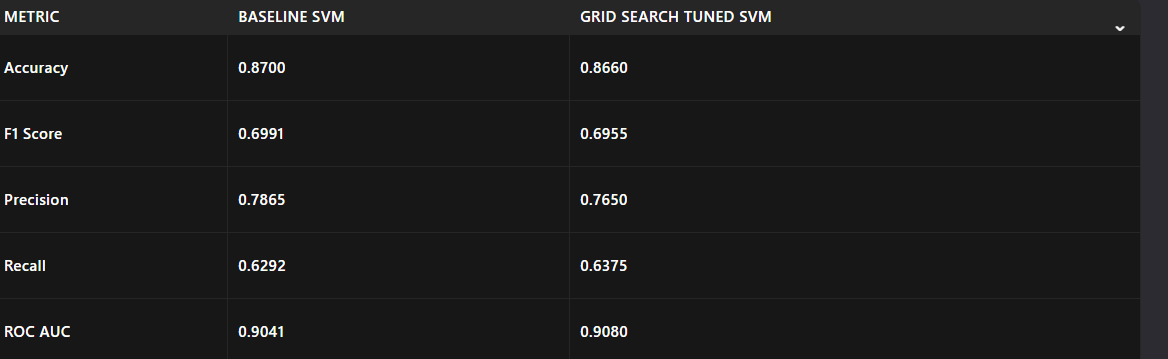

In [ ]:
print("Metric         | Baseline SVM | Grid Search Tuned SVM")
print("---------------------------------------------------")
all_metrics = sorted(list(set(baseline_metrics.keys()) | set(tuned_metrics_gs.keys())))

for metric in all_metrics:
    baseline_val = baseline_metrics.get(metric, np.nan)
    tuned_gs_val = tuned_metrics_gs.get(metric, np.nan)

    baseline_str = f"{baseline_val:.4f}" if pd.notna(baseline_val) else "N/A     "
    tuned_gs_str = f"{tuned_gs_val:.4f}" if pd.notna(tuned_gs_val) else "N/A     "

    print(f"{metric:<14} | {baseline_str}     | {tuned_gs_str}")

print(f"\nTuning Time (seconds): Baseline: {train_time_baseline:.4f}, Grid Search: {tuning_time_gs:.4f}")

# Hybird BFO+PSO

In [12]:
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from joblib import Parallel, delayed

# Define search space
def initialize_search_space():
    C_min, C_max = 0.1, 100
    gamma_min, gamma_max = 0.1, 10
    kernels = ['linear', 'rbf']
    return C_min, C_max, gamma_min, gamma_max, kernels

# Cost function with caching
cost_cache = {}

def cost_function(params, X_train, y_train, preprocessor, kernel_list=['linear', 'rbf']):
    param_key = tuple(params)
    if param_key in cost_cache:
        return cost_cache[param_key]

    C, gamma, kernel_idx = params
    kernel = kernel_list[int(kernel_idx)]

    # Build pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('svc', SVC(C=C, gamma=gamma, kernel=kernel, random_state=42, probability=True))
    ])

    # Evaluate using cross-validation
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')
        score = float(np.mean(scores))
    except Exception as e:
        print(f"Error evaluating parameters {params}: {e}")
        score = -np.inf

    cost_cache[param_key] = score
    return score

# Parallel evaluation
def evaluate_parallel(population, X_train, y_train, preprocessor, kernel_list):
    results = Parallel(n_jobs=-1)(
        delayed(cost_function)(p, X_train, y_train, preprocessor, kernel_list)
        for p in population
    )
    return results

# PSO Component
class PSOOptimizer:
    def __init__(self, X_train, y_train, preprocessor, n_particles=10, max_iter=10,
                 C_min=0.1, C_max=100, gamma_min=0.1, gamma_max=10, kernel_list=['linear', 'rbf']):
        self.X_train = X_train
        self.y_train = y_train
        self.preprocessor = preprocessor
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.C_min = C_min
        self.C_max = C_max
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max
        self.kernel_list = kernel_list
        self.dim = 3  # C, gamma, kernel_index
        self.bounds = [
            [0, 1],     # normalized C
            [0, 1],     # normalized gamma
            [0, len(kernel_list) - 1]  # kernel index
        ]

        # Initialize particles
        self.positions = np.random.rand(self.n_particles, self.dim)
        self.velocities = np.zeros((self.n_particles, self.dim))
        self.pbest_positions = self.positions.copy()
        self.pbest_scores = [-np.inf] * self.n_particles
        self.gbest_position = None
        self.gbest_score = -np.inf

    def optimize(self):
        for _ in range(self.max_iter):
            decoded_pop = []
            for pos in self.positions:
                C = 10 ** (pos[0] * (np.log10(self.C_max) - np.log10(self.C_min)) + np.log10(self.C_min))
                gamma = 10 ** (pos[1] * (np.log10(self.gamma_max) - np.log10(self.gamma_min)) + np.log10(self.gamma_min))
                kernel_idx = int(np.clip(pos[2], 0, len(self.kernel_list) - 1))
                decoded_pop.append([C, gamma, kernel_idx])

            scores = evaluate_parallel(decoded_pop, self.X_train, self.y_train, self.preprocessor, self.kernel_list)

            for i, score in enumerate(scores):
                if score > self.pbest_scores[i]:
                    self.pbest_scores[i] = score
                    self.pbest_positions[i] = self.positions[i].copy()
                if score > self.gbest_score:
                    self.gbest_score = score
                    self.gbest_position = self.positions[i].copy()

            # Update velocities and positions
            w = 0.7
            c1, c2 = 1.5, 1.5
            r1, r2 = np.random.rand(2)

            for i in range(self.n_particles):
                self.velocities[i] = (
                    w * self.velocities[i]
                    + c1 * r1 * (self.pbest_positions[i] - self.positions[i])
                    + c2 * r2 * (self.gbest_position - self.positions[i])
                )
                self.positions[i] = np.clip(self.positions[i] + self.velocities[i],
                                            [b[0] for b in self.bounds],
                                            [b[1] for b in self.bounds])

        # Decode gbest
        C = 10 ** (self.gbest_position[0] * (np.log10(self.C_max) - np.log10(self.C_min)) + np.log10(self.C_min))
        gamma = 10 ** (self.gbest_position[1] * (np.log10(self.gamma_max) - np.log10(self.gamma_min)) + np.log10(self.gamma_min))
        kernel_idx = int(np.clip(self.gbest_position[2], 0, len(self.kernel_list) - 1))
        return [C, gamma, self.kernel_list[kernel_idx]], self.gbest_score


# BFO Component
def chemotaxis(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, X_train, y_train, preprocessor):
    new_bacteria = []
    for bacterium in bacteria:
        C, gamma, kernel_idx = bacterium  # This is now an integer index

        if np.random.rand() < 0.5:
            delta_C = np.random.uniform(-0.1, 0.1)
            delta_gamma = np.random.uniform(-0.01, 0.01)
            new_C = np.clip(C + delta_C, C_min, C_max)
            new_gamma = np.clip(gamma + delta_gamma, gamma_min, gamma_max)
            new_kernel_idx = kernel_idx  # Keep same kernel
        else:
            new_C = C * (1 + np.random.normal(0, 0.1))
            new_gamma = gamma * (1 + np.random.normal(0, 0.1))
            new_C = np.clip(new_C, C_min, C_max)
            new_gamma = np.clip(new_gamma, gamma_min, gamma_max)
            new_kernel_idx = np.random.randint(len(kernels))  # Random kernel index

        new_bacterium = (new_C, new_gamma, new_kernel_idx)

        new_score = cost_function(new_bacterium, X_train, y_train, preprocessor, kernels)
        old_score = cost_function(bacterium, X_train, y_train, preprocessor, kernels)

        if new_score > old_score:
            new_bacteria.append(new_bacterium)
        else:
            new_bacteria.append(bacterium)
    return new_bacteria
    
def initialize_bacteria(S, C_min, C_max, gamma_min, gamma_max, kernels):
    return [
        (
            10 ** np.random.uniform(np.log10(C_min), np.log10(C_max)),
            10 ** np.random.uniform(np.log10(gamma_min), np.log10(gamma_max)),
            np.random.randint(len(kernels))  # Use index instead of string
        )
        for _ in range(S)
    ]

def reproduction(bacteria, X_train, y_train, S, C_min, C_max, gamma_min, gamma_max, kernels, preprocessor):
    scores = [cost_function(b, X_train, y_train, preprocessor, kernels) for b in bacteria]
    sorted_indices = np.argsort(scores)[-S//2:]
    best_half = [bacteria[i] for i in sorted_indices]
    return best_half * 2

def elimination_dispersal(bacteria, Ped, C_min, C_max, gamma_min, gamma_max, kernels):
    return [
        initialize_bacteria(1, C_min, C_max, gamma_min, gamma_max, kernels)[0]
        if np.random.rand() < Ped else b for b in bacteria
    ]


# Hybrid PSO+BFO Optimizer
def hybrid_pso_bfo_optimize(X_train, y_train, preprocessor, n_particles=10, max_pso_iter=10,
                            S=8, Nc=5, Nre=2, Ned=2, Ped=0.25, verbose=1):
    C_min, C_max, gamma_min, gamma_max, kernels = initialize_search_space()

    # Step 1: PSO for global search
    if verbose:
        print("Starting PSO for global search...")
    pso = PSOOptimizer(X_train, y_train, preprocessor, n_particles, max_pso_iter, 
                       C_min, C_max, gamma_min, gamma_max, kernels)
    pso_best, pso_score = pso.optimize()
    if verbose:
        print(f"PSO Best: {pso_best}, Score: {pso_score:.4f}")

    # Step 2: BFO for local refinement
    if verbose:
        print("Starting BFO for local refinement...")

    best_C, best_gamma, best_kernel = pso_best
    kernel_idx = kernels.index(best_kernel)  # Convert string to index
    bacteria = [(best_C, best_gamma, kernel_idx)] + initialize_bacteria(S-1, C_min, C_max, gamma_min, gamma_max, kernels)

    for ed in range(Ned):
        for re in range(Nre):
            for _ in range(Nc):
                bacteria = chemotaxis(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, X_train, y_train, preprocessor)
            bacteria = reproduction(bacteria, X_train, y_train, S, C_min, C_max, gamma_min, gamma_max, kernels, preprocessor)
        bacteria = elimination_dispersal(bacteria, Ped, C_min, C_max, gamma_min, gamma_max, kernels)

    scores = [cost_function(b, X_train, y_train, preprocessor, kernels) for b in bacteria]
    best_idx = np.argmax(scores)
    best_params = bacteria[best_idx]
    best_score = scores[best_idx]

    if verbose:
        print(f"Hybrid PSO+BFO Best: {best_params}, Score: {best_score:.4f}")

    return {
        "params": {
            "C": best_params[0],
            "gamma": best_params[1],
            "kernel": kernels[best_params[2]]  # Convert index back to name
        },
        "score": best_score
    }

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of independent runs
num_runs = 30

# List to store results
run_results = []

print("Starting 30 independent runs of Hybrid PSO+BFO...\n")

for run in range(num_runs):
    # Set unique random state for each run
    random_seed = np.random.randint(0, 10000)
    np.random.seed(random_seed)

    print(f"\n--- Run {run + 1}/{num_runs} ---")
    print(f"Using random seed: {random_seed}")

    # Run optimization
    result = hybrid_pso_bfo_optimize(
        X_train=X_train,
        y_train=y_train,
        preprocessor=preprocessor,
        n_particles=10,
        max_pso_iter=10,
        S=8,
        Nc=3,
        Nre=2,
        Ned=2,
        Ped=0.25,
        verbose=0
    )

    # Extract metrics
    params = result["params"]
    score = result["score"]

    # Save result
    run_results.append({
        'run': run + 1,
        'seed': random_seed,
        'C': params['C'],
        'gamma': params['gamma'],
        'kernel': params['kernel'],
        'score': score
    })

    print(f"Best Score: {score:.4f}")
    print(f"Best Params: {params}")

# Convert to DataFrame for analysis
results_df = pd.DataFrame(run_results)

# Save to CSV (optional)
results_df.to_csv('pso_bfo_hyperparameter_runs.csv', index=False)

# Find best run
best_run = results_df.loc[results_df['score'].idxmax()]

# Print final summary
print("\n=== Final Summary Across All Runs ===")
print(f"Total Runs: {num_runs}")
print(f"Best Score: {best_run['score']:.4f}")
print(f"At Run #: {best_run['run']}")
print(f"With Seed: {best_run['seed']}")
print(f"Best Parameters:")
print(f"  C: {best_run['C']:.4f}")
print(f"  gamma: {best_run['gamma']:.4f}")
print(f"  kernel: {best_run['kernel']}")



Starting 30 independent runs of Hybrid PSO+BFO...


--- Run 1/30 ---
Using random seed: 5003
Best Score: 0.6571
Best Params: {'C': 0.8928913390421921, 'gamma': 0.1707882265462986, 'kernel': 'linear'}

--- Run 2/30 ---
Using random seed: 9984
Best Score: 0.6567
Best Params: {'C': 0.8812994161017292, 'gamma': 2.7104244877279027, 'kernel': 'linear'}

--- Run 3/30 ---
Using random seed: 8633
Best Score: 0.6548
Best Params: {'C': 96.9506624305697, 'gamma': 5.55710986917823, 'kernel': 'linear'}

--- Run 4/30 ---
Using random seed: 1048
Best Score: 0.6571
Best Params: {'C': 0.8883631302267677, 'gamma': 0.21587324948802017, 'kernel': 'linear'}

--- Run 5/30 ---
Using random seed: 9100
Best Score: 0.6549
Best Params: {'C': 1.248172557800784, 'gamma': 0.6759315888479985, 'kernel': 'linear'}

--- Run 6/30 ---
Using random seed: 6800
Best Score: 0.6564
Best Params: {'C': 0.9025431053641699, 'gamma': 1.3988188639734136, 'kernel': 'linear'}

--- Run 7/30 ---
Using random seed: 1469
Best Score: 0.657

# BFO Algorithm

In [14]:
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import Parallel, delayed
import time


cost_cache = {}

def initialize_search_space():
    C_min, C_max = 0.1, 100 
    gamma_min, gamma_max = 0.1, 10  
    kernels = ['linear', 'rbf']  
    return C_min, C_max, gamma_min, gamma_max, kernels

def cost_function(params, X_train, y_train):
    
    param_key = tuple(params)
    if param_key in cost_cache:
        return cost_cache[param_key]
    
    C, gamma, kernel = params
    bfo_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('svc', SVC(random_state=42, probability=True))
    ])
    cv_strategy = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)  
    bfo_pipeline.set_params(svc__C=C, svc__gamma=gamma, svc__kernel=kernel)
    scores = cross_val_score(bfo_pipeline, X_train, y_train, cv=cv_strategy, scoring='accuracy')
    
    result = float(np.mean(scores))
    cost_cache[param_key] = result
    return result

def evaluate_bacteria_parallel(bacteria, X_train, y_train):
    return Parallel(n_jobs=4)(  # Limit to 4 jobs
        delayed(cost_function)(bacterium, X_train, y_train) for bacterium in bacteria
    )

def initialize_bacteria(S, C_min, C_max, gamma_min, gamma_max, kernels):
    bacteria = []
    for _ in range(S):
        C = 10 ** np.random.uniform(np.log10(C_min), np.log10(C_max))
        gamma = 10 ** np.random.uniform(np.log10(gamma_min), np.log10(gamma_max))
        kernel = np.random.choice(kernels)
        bacteria.append((C, gamma, kernel))
    return bacteria

def Chemotaxis(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, X_train, y_train, min_improvement=1e-4):
    new_bacteria = []
    for bacterium in bacteria:
        C, gamma, kernel = bacterium
        current_fitness = cost_function(bacterium, X_train, y_train)

        if np.random.rand() < 0.5:
            # Swim
            new_C = C + np.random.uniform(-0.1, 0.1)
            new_gamma = gamma + np.random.uniform(-0.01, 0.01)
            new_kernel = kernel
        else:
            # Tumble
            new_C = C * (1 + np.random.normal(0, 0.1))
            new_gamma = gamma * (1 + np.random.normal(0, 0.1))
            new_kernel = np.random.choice(kernels)
        
        new_C = np.clip(new_C, C_min, C_max)
        new_gamma = np.clip(new_gamma, gamma_min, gamma_max)

        new_cost = cost_function((new_C, new_gamma, new_kernel), X_train, y_train)

        if new_cost > current_fitness + min_improvement:  # Early stopping threshold
            new_bacteria.append((new_C, new_gamma, new_kernel))
        else:
            new_bacteria.append(bacterium)
    return new_bacteria

def reproduction(bacteria, X_train, y_train, S):
    fitness_scores = evaluate_bacteria_parallel(bacteria, X_train, y_train)
    sorted_indices = np.argsort(fitness_scores)
    best_half = [bacteria[i] for i in sorted_indices[-S//2:]]
    return best_half * 2

def elimination_dispersal(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, Ped):
    new_bacteria = []
    for bacterium in bacteria:
        if np.random.rand() < Ped:
            new_C = 10 ** np.random.uniform(np.log10(C_min), np.log10(C_max))
            new_gamma = 10 ** np.random.uniform(np.log10(gamma_min), np.log10(gamma_max))
            new_kernel = np.random.choice(kernels)
            new_bacteria.append((new_C, new_gamma, new_kernel))
        else:
            new_bacteria.append(bacterium)
    return new_bacteria

def BFO(X_train, y_train, S, Nc, Nre, Ned, Ped, C_min, C_max, gamma_min, gamma_max, kernels):
    bacteria = initialize_bacteria(S, C_min, C_max, gamma_min, gamma_max, kernels)
    best_fitness = -np.inf
    best_params = None
    
    for l in range(Ned):
        for k in range(Nre):
            for j in range(Nc):
                bacteria = Chemotaxis(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, X_train, y_train)
            bacteria = reproduction(bacteria, X_train, y_train, S)
        bacteria = elimination_dispersal(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, Ped)
    
    fitness_scores = evaluate_bacteria_parallel(bacteria, X_train, y_train)
    best_index = np.argmax(fitness_scores)
    best_params = bacteria[best_index]
    best_fitness = fitness_scores[best_index]
    return best_params, best_fitness

# BFO parameters (reduced for speed)
S = 8    
Nc = 10  
Nre = 2  
Ned = 1  
Ped = 0.25

# Initialize search space
C_min, C_max, gamma_min, gamma_max, kernels = initialize_search_space()

# Run BFO multiple times
num_runs = 30  
accuracies = []
results = []
for run in range(num_runs):
    random_seed = np.random.randint(0, 1000)
    np.random.seed(random_seed)
    print(f"Run {run+1} with random seed {random_seed}")
    start = time.time()
    best_params, best_fitness = BFO(X_train, y_train, S, Nc, Nre, Ned, Ped, C_min, C_max, gamma_min, gamma_max, kernels)
    duration = time.time() - start
    accuracies.append(best_fitness)
    print(f"Best params: {best_params}, Best Fitness: {best_fitness}, Time: {duration:.2f} seconds")
    results.append(best_params,best_fitness)

print(f"Mean Accuracy: {np.mean(accuracies):.4f}, Std: {np.std(accuracies):.4f}")



Run 1 with random seed 41
Best params: (0.6329966027312264, 0.11669992682963046, 'rbf'), Best Fitness: 0.85475, Time: 445.53 seconds
Run 2 with random seed 580
Best params: (0.40560150811246976, 8.931187617627717, 'linear'), Best Fitness: 0.8505, Time: 541.54 seconds
Run 3 with random seed 275
Best params: (0.8036956627896288, 0.14364901595201351, 'rbf'), Best Fitness: 0.85425, Time: 434.10 seconds
Run 4 with random seed 854
Best params: (0.7427250882024803, 0.16220613571694426, 'rbf'), Best Fitness: 0.8515, Time: 517.23 seconds
Run 5 with random seed 978
Best params: (0.4032447585985496, 0.7475040934022544, 'linear'), Best Fitness: 0.85025, Time: 678.91 seconds
Run 6 with random seed 666
Best params: (0.404765702039493, 3.1762517895633247, 'linear'), Best Fitness: 0.8505, Time: 562.52 seconds
Run 7 with random seed 708
Best params: (1.3231802158465513, 0.15204613700314293, 'rbf'), Best Fitness: 0.85175, Time: 767.22 seconds
Run 8 with random seed 622
Best params: (0.13452322244455184,

In [ ]:
overall_best = max(results, key=lambda x: x[1])
print(f"Overall Best Params: {overall_best[0]}, Overall Best Fitness: {overall_best[1]}")

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_runs + 1), accuracies, marker='o', linestyle='-', color='b')
plt.title("Accuracy Across 30 Runs")
plt.xlabel("Run Number")
plt.ylabel("Best Accuracy")
plt.grid(True)
plt.show()

# with Swarming

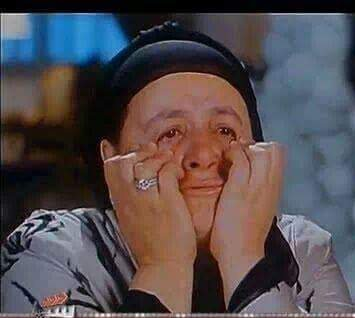

In [14]:
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from joblib import Parallel, delayed
import time

# Assuming preprocessor, X_train, y_train are defined elsewhere
cost_cache = {}

# Adjusted swarming parameters
d_attract = 0.1      # Reduced attraction
omega_attract = 1.0  # Keep attraction localized
h_repellent = 0.2    # Reduced repulsion (was 0.5)
omega_repellent = 0.5  # Increased to make repulsion more localized (was 0.05)

def initialize_search_space():
    C_min, C_max = 0.1, 100 
    gamma_min, gamma_max = 0.1, 10  
    kernels = ['linear', 'rbf']  
    return C_min, C_max, gamma_min, gamma_max, kernels

def compute_swarming_cost(theta, bacteria, C_min, C_max, gamma_min, gamma_max):
    C, gamma, _ = theta
    
    # Normalize C and gamma to [0, 1]
    C_norm = (np.log10(C) - np.log10(C_min)) / (np.log10(C_max) - np.log10(C_min))
    gamma_norm = (np.log10(gamma) - np.log10(gamma_min)) / (np.log10(gamma_max) - np.log10(gamma_min))
    theta_norm = np.array([C_norm, gamma_norm])
    
    attract_sum = 0
    repel_sum = 0
    
    for bacterium in bacteria:
        C_i, gamma_i, _ = bacterium
        C_i_norm = (np.log10(C_i) - np.log10(C_min)) / (np.log10(C_max) - np.log10(C_min))
        gamma_i_norm = (np.log10(gamma_i) - np.log10(gamma_min)) / (np.log10(gamma_max) - np.log10(gamma_min))
        theta_i_norm = np.array([C_i_norm, gamma_i_norm])
        
        squared_dist = np.sum((theta_norm - theta_i_norm) ** 2)
        
        attract_sum += -d_attract * np.exp(-omega_attract * squared_dist)
        repel_sum += h_repellent * np.exp(-omega_repellent * squared_dist)
    
    J_cc = attract_sum + repel_sum
    return J_cc

def cost_function(params, X_train, y_train, bacteria=None, C_min=None, C_max=None, gamma_min=None, gamma_max=None):
    """
    Returns a tuple of (accuracy, combined_fitness) if bacteria is provided, else just accuracy.
    """
    param_key = tuple(params)
    if param_key in cost_cache:
        return cost_cache[param_key]
    
    C, gamma, kernel = params
    bfo_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('svc', SVC(random_state=42, probability=True))
    ])
    cv_strategy = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    bfo_pipeline.set_params(svc__C=C, svc__gamma=gamma, svc__kernel=kernel)
    scores = cross_val_score(bfo_pipeline, X_train, y_train, cv=cv_strategy, scoring='accuracy')
    
    accuracy = float(np.mean(scores))
    
    if bacteria is not None:
        J_cc = compute_swarming_cost(params, bacteria, C_min, C_max, gamma_min, gamma_max)
        combined_fitness = accuracy + J_cc
        result = (accuracy, combined_fitness)
    else:
        result = accuracy
    
    cost_cache[param_key] = result
    return result

def evaluate_bacteria_parallel(bacteria, X_train, y_train, C_min, C_max, gamma_min, gamma_max, for_chemotaxis=False):
    results = Parallel(n_jobs=4)(
        delayed(cost_function)(
            bacterium, X_train, y_train, bacteria, C_min, C_max, gamma_min, gamma_max
        ) for bacterium in bacteria
    )
    if for_chemotaxis:
        # Return combined fitness (accuracy + J_cc) for chemotaxis
        return [result[1] for result in results]
    else:
        # Return only accuracy for reproduction and final evaluation
        return [result[0] for result in results]

def initialize_bacteria(S, C_min, C_max, gamma_min, gamma_max, kernels):
    bacteria = []
    for _ in range(S):
        C = 10 ** np.random.uniform(np.log10(C_min), np.log10(C_max))
        gamma = 10 ** np.random.uniform(np.log10(gamma_min), np.log10(gamma_max))
        kernel = np.random.choice(kernels)
        bacteria.append((C, gamma, kernel))
    return bacteria

def Chemotaxis(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, X_train, y_train, min_improvement=1e-4):
    new_bacteria = []
    # Use combined fitness (accuracy + J_cc) for movement decisions
    current_fitnesses = evaluate_bacteria_parallel(bacteria, X_train, y_train, C_min, C_max, gamma_min, gamma_max, for_chemotaxis=True)

    for idx, bacterium in enumerate(bacteria):
        C, gamma, kernel = bacterium
        current_fitness = current_fitnesses[idx]

        if np.random.rand() < 0.5:
            new_C = C + np.random.uniform(-0.1, 0.1)
            new_gamma = gamma + np.random.uniform(-0.01, 0.01)
            new_kernel = kernel
        else:
            new_C = C * (1 + np.random.normal(0, 0.1))
            new_gamma = gamma * (1 + np.random.normal(0, 0.1))
            new_kernel = np.random.choice(kernels)
        
        new_C = np.clip(new_C, C_min, C_max)
        new_gamma = np.clip(new_gamma, gamma_min, gamma_max)

        new_bacterium = (new_C, new_gamma, new_kernel)
        new_cost = cost_function(new_bacterium, X_train, y_train, bacteria, C_min, C_max, gamma_min, gamma_max)[1]  # Use combined fitness

        if new_cost > current_fitness + min_improvement:
            new_bacteria.append(new_bacterium)
        else:
            new_bacteria.append(bacterium)
    return new_bacteria

def reproduction(bacteria, X_train, y_train, S, C_min, C_max, gamma_min, gamma_max):
    # Use only accuracy for reproduction
    fitness_scores = evaluate_bacteria_parallel(bacteria, X_train, y_train, C_min, C_max, gamma_min, gamma_max, for_chemotaxis=False)
    sorted_indices = np.argsort(fitness_scores)
    best_half = [bacteria[i] for i in sorted_indices[-S//2:]]
    return best_half * 2

def elimination_dispersal(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, Ped):
    new_bacteria = []
    for bacterium in bacteria:
        if np.random.rand() < Ped:
            new_C = 10 ** np.random.uniform(np.log10(C_min), np.log10(C_max))
            new_gamma = 10 ** np.random.uniform(np.log10(gamma_min), np.log10(gamma_max))
            new_kernel = np.random.choice(kernels)
            new_bacteria.append((new_C, new_gamma, new_kernel))
        else:
            new_bacteria.append(bacterium)
    return new_bacteria

def BFO(X_train, y_train, S, Nc, Nre, Ned, Ped, C_min, C_max, gamma_min, gamma_max, kernels):
    bacteria = initialize_bacteria(S, C_min, C_max, gamma_min, gamma_max, kernels)
    best_fitness = -np.inf
    best_params = None
    
    for l in range(Ned):
        for k in range(Nre):
            for j in range(Nc):
                bacteria = Chemotaxis(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, X_train, y_train)
            bacteria = reproduction(bacteria, X_train, y_train, S, C_min, C_max, gamma_min, gamma_max)
        bacteria = elimination_dispersal(bacteria, C_min, C_max, gamma_min, gamma_max, kernels, Ped)
    
    # Use only accuracy for final evaluation
    fitness_scores = evaluate_bacteria_parallel(bacteria, X_train, y_train, C_min, C_max, gamma_min, gamma_max, for_chemotaxis=False)
    best_index = np.argmax(fitness_scores)
    best_params = bacteria[best_index]
    best_fitness = fitness_scores[best_index]
    return best_params, best_fitness

# BFO parameters
S = 8
Nc = 10
Nre = 3
Ned = 2
Ped = 0.25

# Initialize search space
C_min, C_max, gamma_min, gamma_max, kernels = initialize_search_space()

# Run BFO multiple times
num_runs = 30
accuracies = []
results = []
for run in range(num_runs):
    random_seed = np.random.randint(0, 1000)
    np.random.seed(random_seed)
    print(f"Run {run+1} with random seed {random_seed}")
    start = time.time()
    best_params, best_fitness = BFO(X_train, y_train, S, Nc, Nre, Ned, Ped, C_min, C_max, gamma_min, gamma_max, kernels)
    duration = time.time() - start
    accuracies.append(best_fitness)
    print(f"Best params: {best_params}, Best Fitness: {best_fitness}, Time: {duration:.2f} seconds")
    results.append((best_params, best_fitness))

print(f"Mean Accuracy: {np.mean(accuracies):.4f}, Std: {np.std(accuracies):.4f}")

Run 1 with random seed 896
Best params: (1.1955377368736313, 0.5813077843424619, 'linear'), Best Fitness: 0.85, Time: 1286.31 seconds
Run 2 with random seed 297
Best params: (0.8961725538478246, 0.1306823221947426, 'rbf'), Best Fitness: 0.8545, Time: 1607.43 seconds
Run 3 with random seed 770
Best params: (0.4316018393519138, 1.266422650500154, 'linear'), Best Fitness: 0.85075, Time: 1051.52 seconds
Run 4 with random seed 91


C:\Users\esraa omaar\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: (3.1842476121540133, 0.1, 'rbf'), Best Fitness: 0.8520000000000001, Time: 6585.71 seconds
Run 5 with random seed 487
Best params: (0.9755865829927735, 0.111827403978053, 'rbf'), Best Fitness: 0.8552500000000001, Time: 1299.96 seconds
Run 6 with random seed 633
Best params: (1.4097223420742897, 0.1, 'rbf'), Best Fitness: 0.8540000000000001, Time: 1722.08 seconds
Run 7 with random seed 888
Best params: (0.4322744683216554, 1.077924346283308, 'linear'), Best Fitness: 0.85075, Time: 1144.39 seconds
Run 8 with random seed 387
Best params: (0.43296177756075516, 1.1160358290099455, 'linear'), Best Fitness: 0.85075, Time: 1064.64 seconds
Run 9 with random seed 148
Best params: (0.43277558138637995, 4.282513103872777, 'linear'), Best Fitness: 0.85075, Time: 1402.68 seconds
Run 10 with random seed 247
Best params: (0.4472566073229857, 9.561594932740556, 'linear'), Best Fitness: 0.85, Time: 1165.42 seconds
Run 11 with random seed 314
Best params: (1.0889514759464485, 0.1, 'rbf'), Bes

KeyboardInterrupt: 

# visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Define the data
data = [
    (1, 41, 0.6329966027312264, 0.11669992682963046, 'rbf', 0.85475, 445.53),
    (2, 580, 0.40560150811246976, 8.931187617627717, 'linear', 0.8505, 541.54),
    (3, 275, 0.8036956627896288, 0.14364901595201351, 'rbf', 0.85425, 434.10),
    (4, 854, 0.7427250882024803, 0.16220613571694426, 'rbf', 0.8515, 517.23),
    (5, 978, 0.4032447585985496, 0.7475040934022544, 'linear', 0.85025, 678.91),
    (6, 666, 0.404765702039493, 3.1762517895633247, 'linear', 0.8505, 562.52),
    (7, 708, 1.3231802158465513, 0.15204613700314293, 'rbf', 0.85175, 767.22),
    (8, 622, 0.13452322244455184, 7.651998052535227, 'linear', 0.8500, 577.58),
    (9, 875, 0.4071453195051593, 2.6847170171766, 'linear', 0.8505, 617.12),
    (10, 9, 0.43187305626570627, 0.620415845108914, 'linear', 0.8505, 556.40),
    (11, 599, 1.1980518343191764, 1.4380575130149762, 'linear', 0.85, 684.94),
    (12, 132, 0.42897122994802833, 5.919977617099127, 'linear', 0.8505, 545.93),
    (13, 168, 0.44296802347401454, 0.9794406787140392, 'linear', 0.85025, 615.16),
    (14, 306, 1.273317492490382, 0.10608613757074124, 'rbf', 0.85425, 564.23),
    (15, 980, 1.7052916030850784, 0.11911814681271257, 'rbf', 0.8535, 836.64),
    (16, 730, 0.40610344225436507, 0.35902193213775324, 'linear', 0.8505, 435.04),
    (17, 773, 0.4316317981052102, 5.209316236164725, 'linear', 0.85075, 521.24),
    (18, 696, 1.1210586414436072, 0.11928513384715726, 'rbf', 0.854, 447.30),
    (19, 672, 1.3727007859414746, 0.10258005431990534, 'rbf', 0.85425, 525.56),
    (20, 732, 0.4573296723057056, 0.12443723915984559, 'rbf', 0.85025, 795.80),
    (21, 394, 0.4017411204192785, 0.24509015388710634, 'linear', 0.85025, 536.54),
    (22, 190, 0.4392980988471644, 3.9664742961110666, 'linear', 0.8505, 782.01),
    (23, 611, 0.76806537780015, 0.15282525590117604, 'rbf', 0.85275, 621.80),
    (24, 796, 1.3366451190421862, 0.10605926707493278, 'rbf', 0.85425, 416.80),
    (25, 130, 0.4046716469770143, 0.18965381756586228, 'linear', 0.8505, 761.30),
    (26, 140, 0.9608314781329377, 0.11250444286278656, 'rbf', 0.85475, 650.42),
    (27, 158, 0.12755543622553023, 1.167387622659543, 'linear', 0.85025, 796.11),
    (28, 499, 0.40652897374419805, 1.551015248524562, 'linear', 0.8505, 574.95),
    (29, 479, 0.6678781868687198, 0.16738574475418827, 'rbf', 0.85025, 450.81),
    (30, 752, 0.16276042596928203, 2.639610021596622, 'linear', 0.8500, 606.28),
]

# Step 2: Create DataFrame
df = pd.DataFrame(data, columns=['Run', 'Seed', 'C', 'Gamma', 'Kernel', 'Fitness', 'Time'])



In [2]:
# Step 3: Save to CSV
df.to_csv("bfo_svm_results.csv", index=False)
print("CSV saved as 'bfo_svm_results.csv'")


CSV saved as 'bfo_svm_results.csv'


In [ ]:
# Step 3: Save to CSV
df.to_csv("bfo_svm_results.csv", index=False)
print("CSV saved as 'bfo_svm_results.csv'")

# Step 4: Visualizations
sns.set(style="whitegrid")

# Fitness vs Run
plt.figure(figsize=(12, 5))
sns.barplot(data=df, x='Run', y='Fitness', hue='Kernel', dodge=False, palette='viridis')
plt.title('Fitness Score per Run by Kernel')
plt.xlabel('Run Number')
plt.ylabel('Fitness Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# C vs Fitness (log scale)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='C', y='Fitness', hue='Kernel', palette='muted')
plt.xscale('log')
plt.title('C vs Fitness (log scale)')
plt.xlabel('C (log scale)')
plt.ylabel('Fitness Score')
plt.tight_layout()
plt.show()

# Gamma vs Fitness
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Gamma', y='Fitness', hue='Kernel', palette='muted')
plt.title('Gamma vs Fitness')
plt.xlabel('Gamma')
plt.ylabel('Fitness Score')
plt.tight_layout()
plt.show()

# Fitness vs Time
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Time', y='Fitness', hue='Kernel', palette='muted')
plt.title('Fitness vs Execution Time')
plt.xlabel('Execution Time (s)')
plt.ylabel('Fitness Score')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

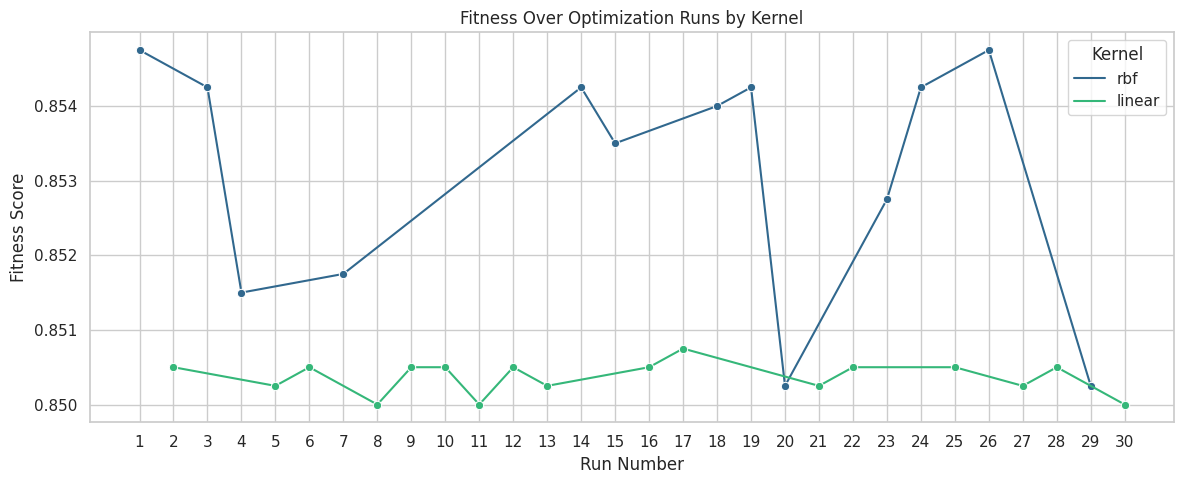

In [7]:
# Step 4: Visualizations
sns.set(style="whitegrid")

# Fitness vs Run
# Better: Fitness vs Run using Line & Scatter Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='Run', y='Fitness', hue='Kernel', marker='o', palette='viridis')
plt.title('Fitness Over Optimization Runs by Kernel')
plt.xlabel('Run Number')
plt.ylabel('Fitness Score')
plt.xticks(df['Run'])  # Show all run numbers
plt.grid(True)
plt.tight_layout()
plt.show()


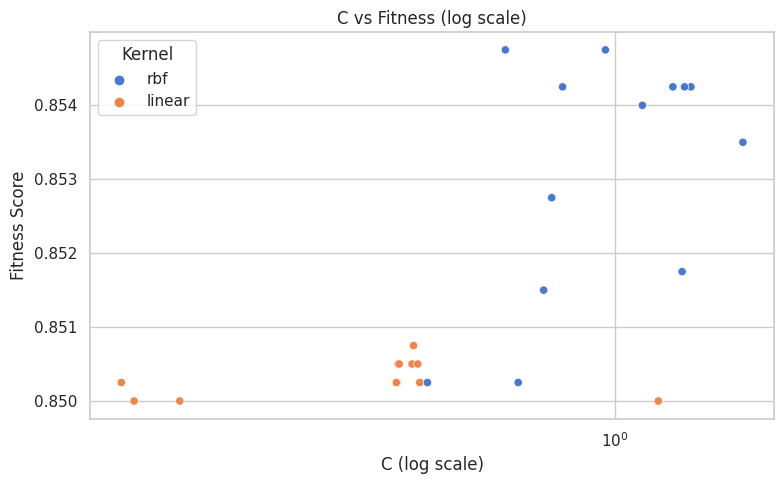

In [4]:
# C vs Fitness (log scale)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='C', y='Fitness', hue='Kernel', palette='muted')
plt.xscale('log')
plt.title('C vs Fitness (log scale)')
plt.xlabel('C (log scale)')
plt.ylabel('Fitness Score')
plt.tight_layout()
plt.show()

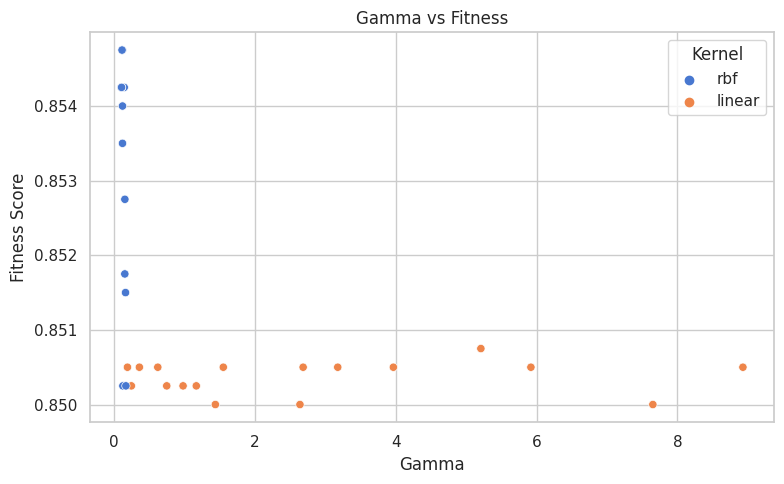

In [5]:
# Gamma vs Fitness
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Gamma', y='Fitness', hue='Kernel', palette='muted')
plt.title('Gamma vs Fitness')
plt.xlabel('Gamma')
plt.ylabel('Fitness Score')
plt.tight_layout()
plt.show()

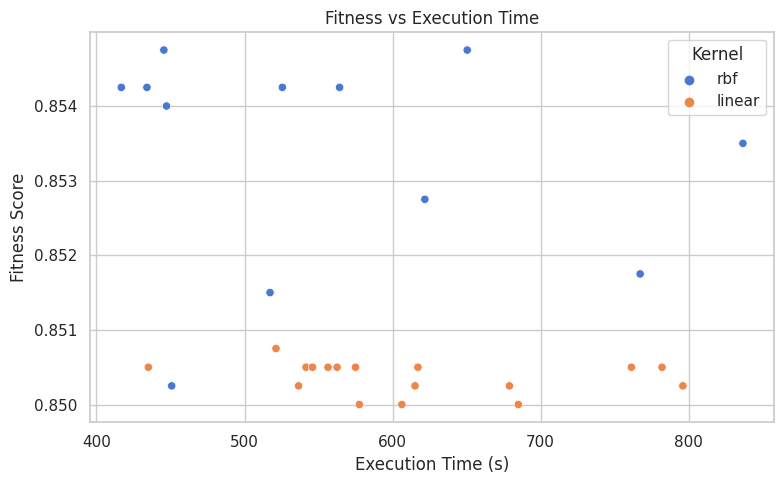

In [6]:
# Fitness vs Time
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Time', y='Fitness', hue='Kernel', palette='muted')
plt.title('Fitness vs Execution Time')
plt.xlabel('Execution Time (s)')
plt.ylabel('Fitness Score')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

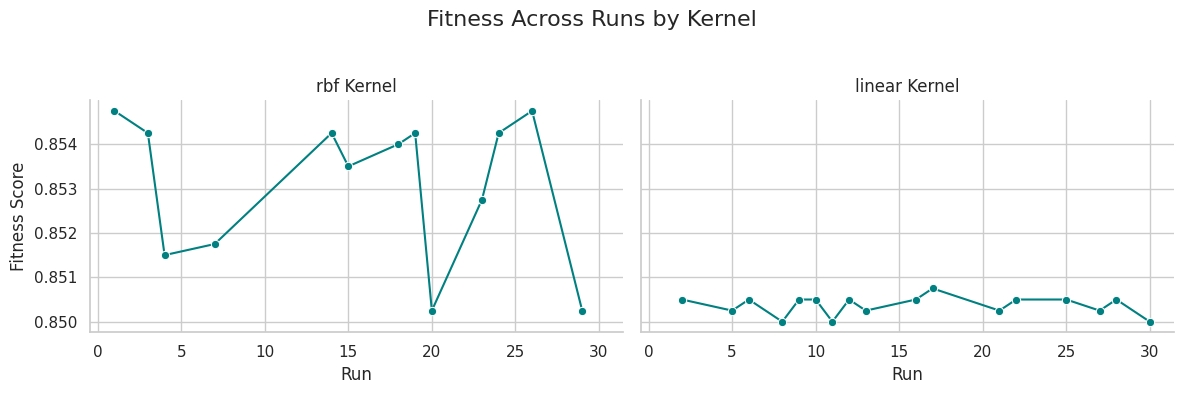

In [8]:
g = sns.FacetGrid(df, col="Kernel", height=4, aspect=1.5, sharey=True)
g.map_dataframe(sns.lineplot, x="Run", y="Fitness", marker="o", color='teal')
g.set_titles(col_template="{col_name} Kernel")
g.set_axis_labels("Run", "Fitness Score")
g.fig.suptitle("Fitness Across Runs by Kernel", fontsize=16)
g.fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


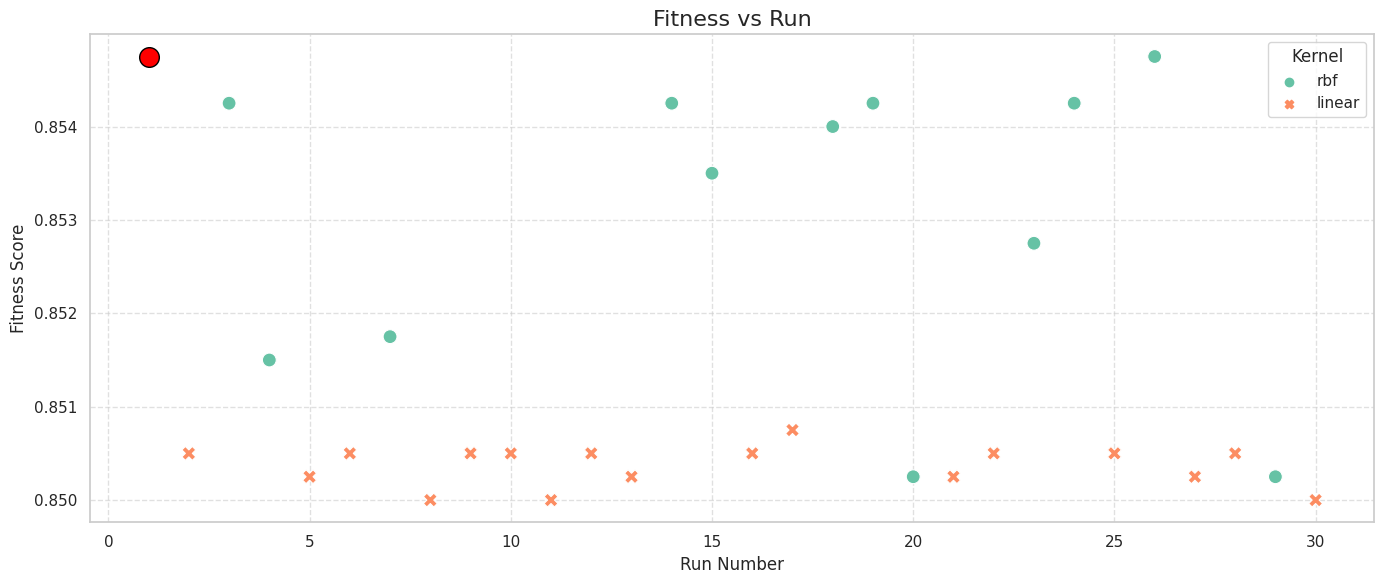

In [11]:
plt.figure(figsize=(14, 6))
sns.scatterplot(data=df, x='Run', y='Fitness', hue='Kernel', style='Kernel', s=100, palette='Set2')
best_idx = df['Fitness'].idxmax()
plt.scatter(df.loc[best_idx, 'Run'], df.loc[best_idx, 'Fitness'], color='red', s=200, edgecolor='black', zorder=5)
plt.title('Fitness vs Run', fontsize=16)

plt.xlabel('Run Number')
plt.ylabel('Fitness Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [15]:
df['C_rounded'] = df['C'].round(2)
df['Gamma_rounded'] = df['Gamma'].round(2)


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


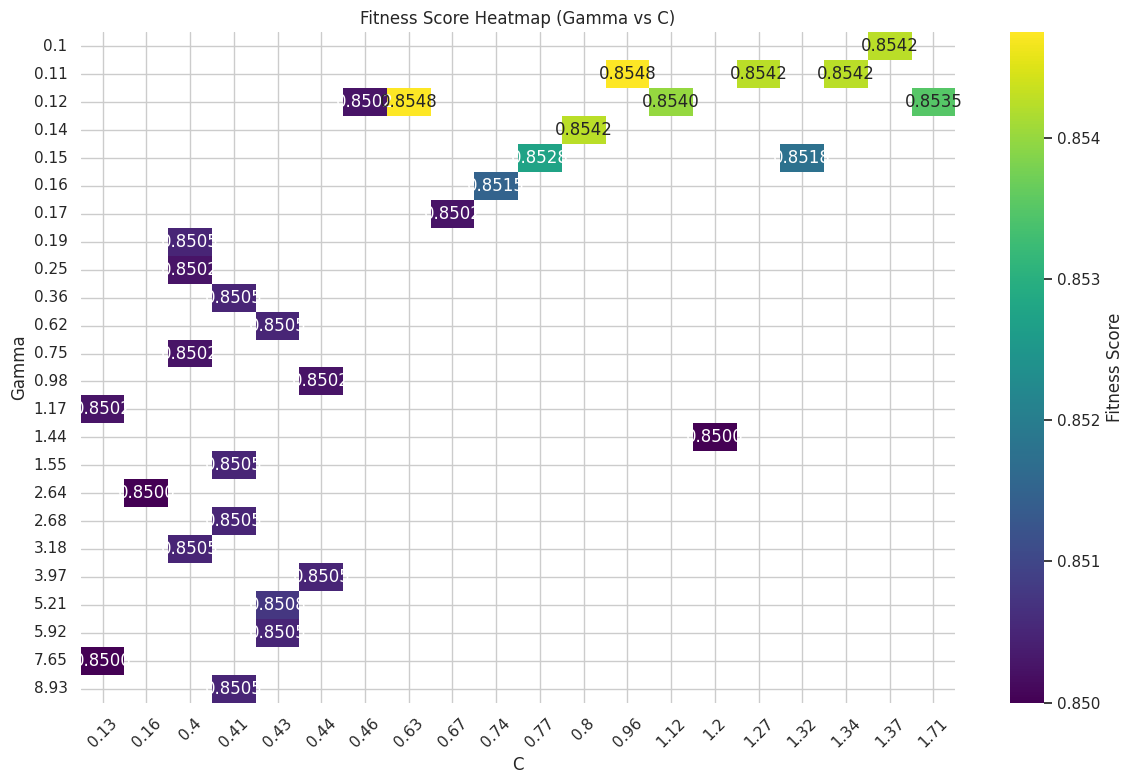

In [16]:
pivot = df.pivot_table(index='Gamma_rounded', columns='C_rounded', values='Fitness')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'Fitness Score'})
plt.title('Fitness Score Heatmap (Gamma vs C)')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# vis with Swiming


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


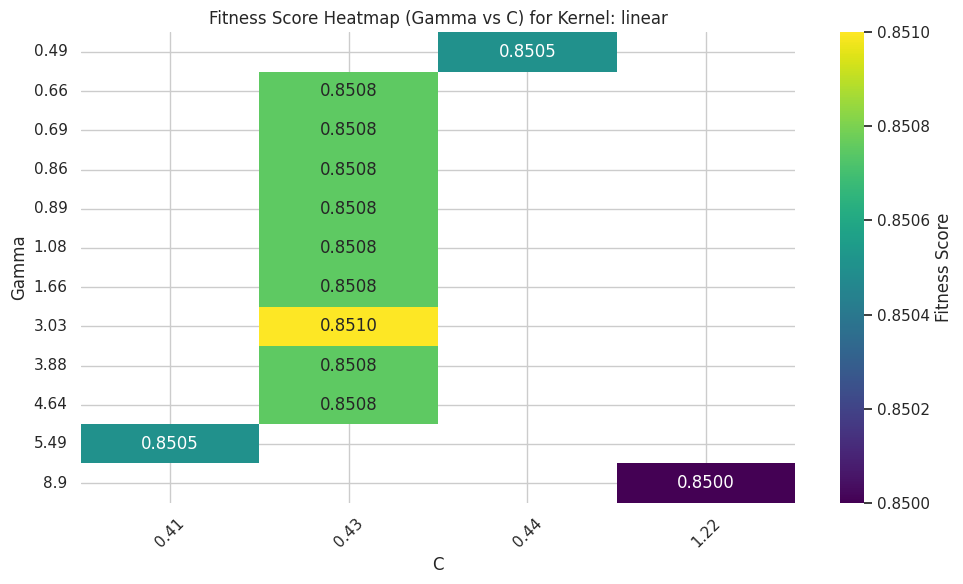

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


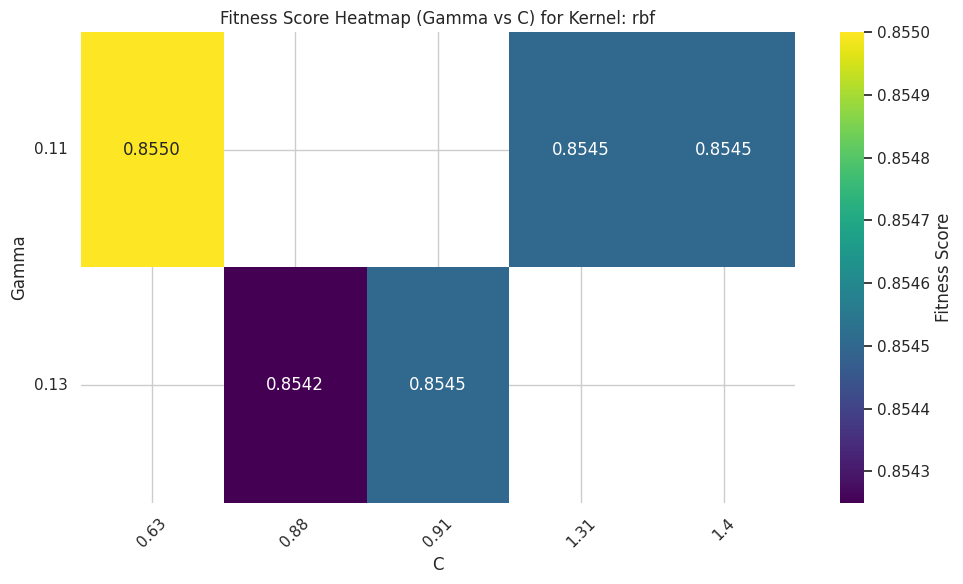

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Your runs data extracted:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your data
data = [
    (0.43142885024589733, 1.6623741340186242, 'linear', 0.85075, 1397.58),
    (0.6331536597007192, 0.11474271580625195, 'rbf', 0.855, 1255.06),
    (0.4317509077254942, 0.8569613022535323, 'linear', 0.85075, 961.64),
    (0.4327844637410641, 4.643310205401877, 'linear', 0.85075, 1032.12),
    (0.4329652932738621, 3.8819094068815843, 'linear', 0.85075, 1098.94),
    (0.43142035733336803, 1.0751115106271973, 'linear', 0.85075, 1094.59),
    (0.906177800966614, 0.13016089548458304, 'rbf', 0.8545, 921.23),
    (0.4347422976300531, 0.8940497719887871, 'linear', 0.85075, 981.29),
    (0.40898706794792167, 5.490367489789047, 'linear', 0.8505, 923.26),
    (1.3992965088123834, 0.10578908188361402, 'rbf', 0.8545, 845.72),
    (0.8789854495006557, 0.1344706134422629, 'rbf', 0.85425, 1313.55),
    (0.4314636084838428, 0.6585715198260232, 'linear', 0.85075, 948.68),
    (1.216689075848914, 8.897039567828266, 'linear', 0.85, 1102.19),
    (0.4380468497295666, 0.49170115123045216, 'linear', 0.8505, 885.99),
    (1.3070359589850213, 0.10517345708626856, 'rbf', 0.8545, 806.02),
    (0.4327930624313505, 0.8850439891651439, 'linear', 0.85075, 1612.70),
    (0.43150736732977846, 0.6905030804797467, 'linear', 0.85075, 941.49),
    (0.4326531194022774, 3.0257531689328365, 'linear', 0.851, 971.20),
]

# Create DataFrame
df = pd.DataFrame(data, columns=['C', 'Gamma', 'Kernel', 'Fitness', 'Time_seconds'])

# Round C and Gamma for cleaner axis labels
df['C_round'] = df['C'].round(2)
df['Gamma_round'] = df['Gamma'].round(2)

for kernel in df['Kernel'].unique():
    subset = df[df['Kernel'] == kernel]
    # Aggregate duplicates by mean fitness
    agg = subset.groupby(['Gamma_round', 'C_round'])['Fitness'].mean().reset_index()
    pivot = agg.pivot(index='Gamma_round', columns='C_round', values='Fitness')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'Fitness Score'})
    plt.title(f'Fitness Score Heatmap (Gamma vs C) for Kernel: {kernel}')
    plt.xlabel('C')
    plt.ylabel('Gamma')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()



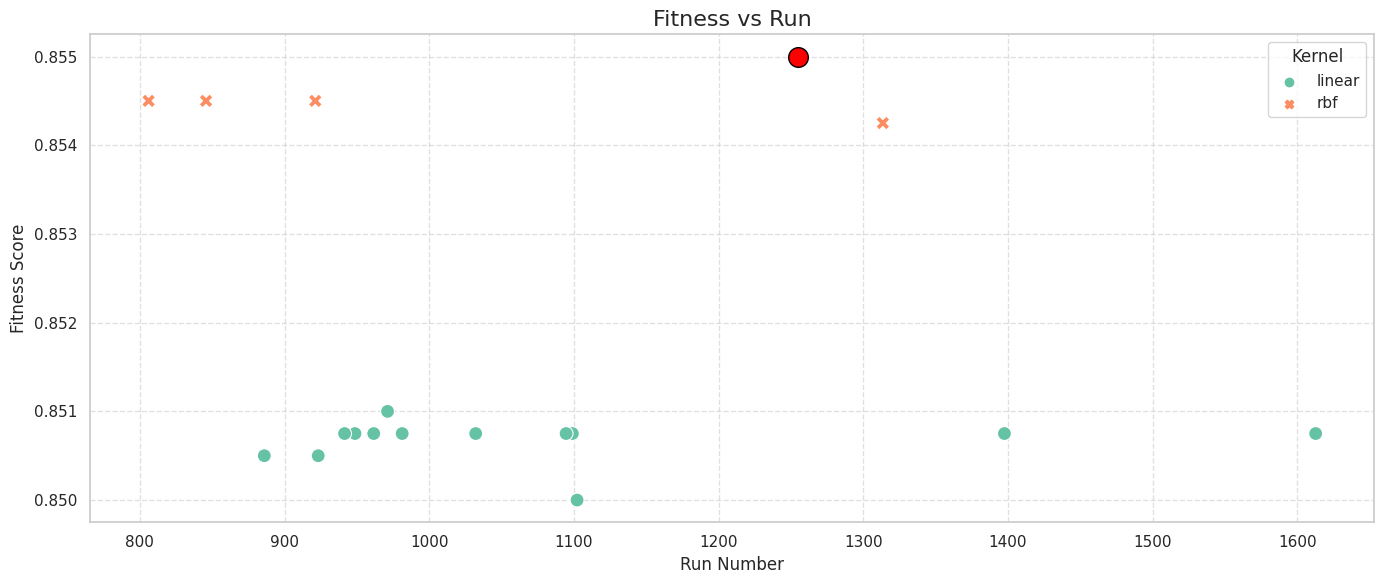

In [24]:
plt.figure(figsize=(14, 6))
sns.scatterplot(data=df, x='Time_seconds', y='Fitness', hue='Kernel', style='Kernel', s=100, palette='Set2')
best_idx = df['Fitness'].idxmax()
plt.scatter(df.loc[best_idx, 'Time_seconds'], df.loc[best_idx, 'Fitness'], color='red', s=200, edgecolor='black', zorder=5)
plt.title('Fitness vs Run', fontsize=16)

plt.xlabel('Run Number')
plt.ylabel('Fitness Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

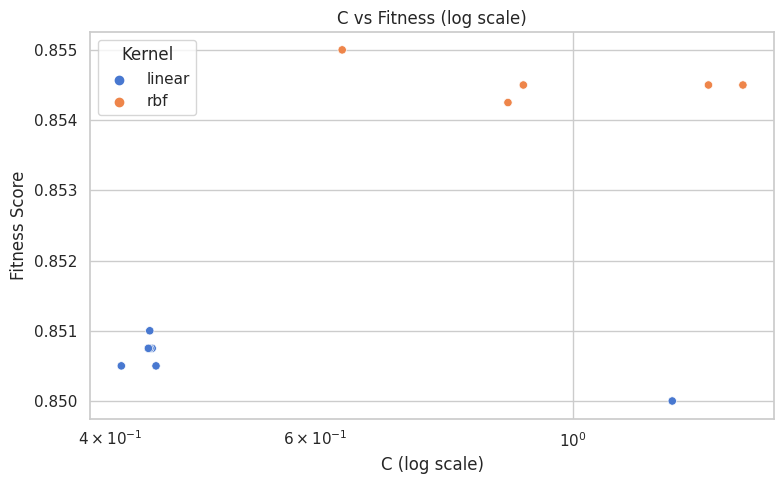

In [25]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='C', y='Fitness', hue='Kernel', palette='muted')
plt.xscale('log')
plt.title('C vs Fitness (log scale)')
plt.xlabel('C (log scale)')
plt.ylabel('Fitness Score')
plt.tight_layout()
plt.show()